# Predict IBM Telco Churn using XGBoost in Python

----

In this notebook will use **XGBoost** to build a collection of boosted trees (one of which is illustrated below), and use continuous and categorical data from **[IBM Base Samples](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2018/09/12/base-samples-for-ibm-cognos-analytics)** to predict whether or not a customer will **[stop using a company's service](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)** called **Customer Churn**. You can download the **[Telco Churn dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2017/06/19/guide-to-ibm-cognos-analytics-sample-data-sets)**, or use the file provided with the jupyther notebook.


**XGBoost** is an exceptionally useful machine learning method when you don't want to sacrifice the ability to correct classify observations but you still want a model that is fairly easy to understand and interpret.

In this notebook consist...

- **[Importing Data from a File](#download-the-data)**

- **[Exploratory Data Analysis](#exploratory-data-analysis)**

- **[Missing Data](#identify-and-deal-with-missing-data)**
    - Indentifying Missing Data
    - Dealing with Missing Data
    
- **[Formatting the Data for XGBoost](#format-the-data)**
    - Splitting data into Dependent and Independent Variables
    - Ordinal Label Encoding (Monotonic relationship)
    - Converting all columns to Int, Float or Bool
    
- **[Building a Prelimary XGBoost Model](#build-tree)**

- **[Optimizing Parameters with Cross Validation and GridSearch](#optimize-parameters)**
    - Optimizing the learning rate, tree depth, number of trees, gamma (for prunning) and lambda (for regularization).
    
- **[Deploy model using pickle](#deploy-model)**


#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and are familiar with the theory behind **[XGBoost](https://youtu.be/OtD8wVaFm6E)**, **[Cross Validation](https://youtu.be/fSytzGwwBVw)**, **[Confusion Matrices](https://youtu.be/Kdsp6soqA7o)**.


#### Also Note:
Strongly encourage to play around with the code. Playing with the code is the best way to learn from it.

-----

# Important the modules that will do all the work
The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the **XGBoost** model.

**NOTE:** You will need **Python 3** and have at least these versions for each of the following modules:
- pandas >= 0.25.1
- numpy >= 1.17.2
- sklearn >= 0.22.1
- xgboost >= 0.90 (Current version 1.1.1)

If you installed **Python 3** with [Anaconda](https://www.anaconda.com/), you can check which versions you have with command: `conda list`. If, for example, your version of `scikit-learn` is older than 0.22.1, then the easiest thing to do is just updaye all of your **Anaconda** packages with the following command: `conda update --all`. However, if you only want to update `scikit-learn`, then you can run this command: `conda install scikit-learn=0.22.1`.

If you need to install `xgboost`, then you can do so with the following command: `conda install -c conda-forge xgboost`.

In [1]:
import pandas as pd # Load and manipulate data and for One-Hot-Encoding
import numpy as np # Calculate the mean and standard deviation
import seaborn as sns # Data visualisation
import matplotlib.pyplot as plt # Data visualisation
import xgboost as xgb # XGBoost stuff
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create a confusion matrix
from sklearn.metrics import classification_report # create classification report
from sklearn.metrics import plot_confusion_matrix # draws a confusion matirx
from sklearn.preprocessing import LabelEncoder # label encode for categorical features
from feature_engine.encoding import OrdinalEncoder # For integer encoding using feature-engine
# from feature_engine.categorical_encoders import OrdinalCategoricalEncoder # For integer encoding using feature-engine
import pickle
file_name = "xgb_IBM_Churn.pkl"
%matplotlib inline

In d:\software\programming\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In d:\software\programming\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In d:\software\programming\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In d:\software\programming\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In d:\software\programming\anaconda3\lib\site-packages\m

----

In [167]:
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'seaborn: {sns.__version__}')
# print(f'matplotlib: {matplotlib.__version__}')
print(f'XGBoost: {xgb.__version__}')
# print(f'scipy: {scipy.__version__}')
# print(f'sklearn: {sklearn.__version__}')
# print(f'feature-engine: {feature_engine.__version__}')
# print(f'pickle: {pickle.__version__}')

pandas: 1.2.2
numpy: 1.20.1
seaborn: 0.10.1
XGBoost: 1.2.0


<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[IBM Base Samples](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2018/09/12/base-samples-for-ibm-cognos-analytics)**. Specifically, we are going to use the **[Telco Churn Dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2017/06/19/guide-to-ibm-cognos-analytics-sample-data-sets)**. This dataset will allow us to predict if someone will stop using Telco's services or not using a variety of continuous and categorical datatypes.

**NOTE:** When **pandas** (**pd**) reads in data, it returns a **data frame**, which is alot like a spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable nama for a **data frame** is the initials **df**, and that is what we will use here:

In [2]:
df = pd.read_csv('Telco_customer_churn.csv')

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the head() function:

In [3]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


Let's explore the last five rows using the tail() function:

In [4]:
df.tail()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN
7042,3186-AJIEK,1,United States,California,Apple Valley,92308,"34.424926, -117.184503",34.424926,-117.184503,Male,...,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No,0,38,5097,NaN


The "..." between **Gender** and **Contract** tells us that this dataset has more columns, or variables, than will print to the screen. And the `5 rows x 33 columns` printed below the first or last 5 rows tells us that there are 33 variables.

Checking out the data and datatype of each variables using info() function:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
df.isnull().mean()

CustomerID           0.00000
Count                0.00000
Country              0.00000
State                0.00000
City                 0.00000
Zip Code             0.00000
Lat Long             0.00000
Latitude             0.00000
Longitude            0.00000
Gender               0.00000
Senior Citizen       0.00000
Partner              0.00000
Dependents           0.00000
Tenure Months        0.00000
Phone Service        0.00000
Multiple Lines       0.00000
Internet Service     0.00000
Online Security      0.00000
Online Backup        0.00000
Device Protection    0.00000
Tech Support         0.00000
Streaming TV         0.00000
Streaming Movies     0.00000
Contract             0.00000
Paperless Billing    0.00000
Payment Method       0.00000
Monthly Charges      0.00000
Total Charges        0.00000
Churn Label          0.00000
Churn Value          0.00000
Churn Score          0.00000
CLTV                 0.00000
Churn Reason         0.73463
dtype: float64

In [7]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

Based on the information above, variables with missing data is **Churn Reason** of 5174 (~73.5%)

In [8]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


<a id="exploratory-data-analysis"></a>
# Exploratory Data Analysis

In [9]:
sns.set_style("darkgrid")

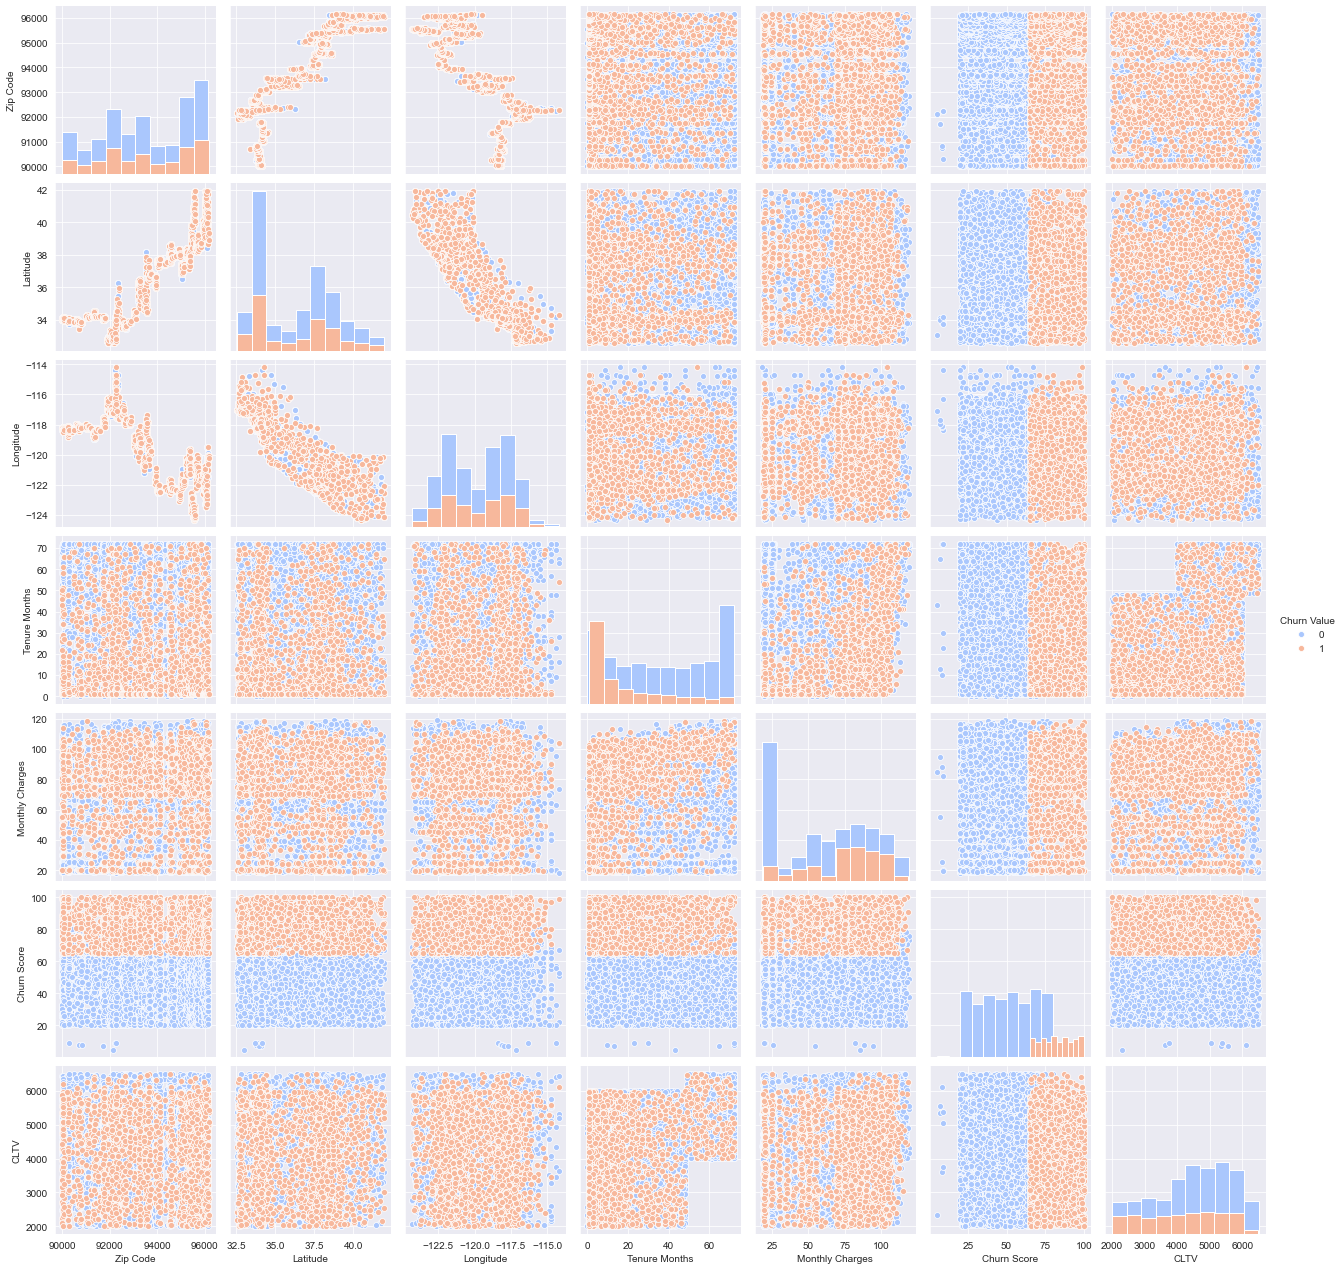

In [10]:
# Pairplot

sns.pairplot(df.drop('Count', axis=1), hue='Churn Value', diag_kind='hist',
             palette='coolwarm')

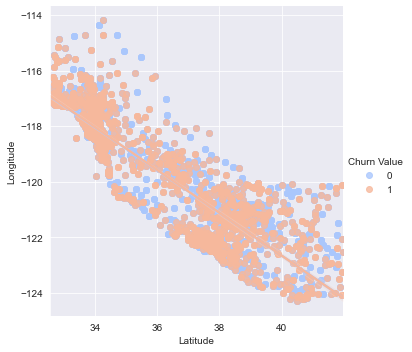

In [11]:
sns.lmplot(x='Latitude', y='Longitude', data=df, hue='Churn Value', palette='coolwarm')

In [12]:
r, p = pearsonr(df['Latitude'], df['Longitude'])

print('Pearsons correlation: %.3f' % r)
print('P-value correlation: ', p)

Pearsons correlation: -0.877
P-value correlation:  0.0


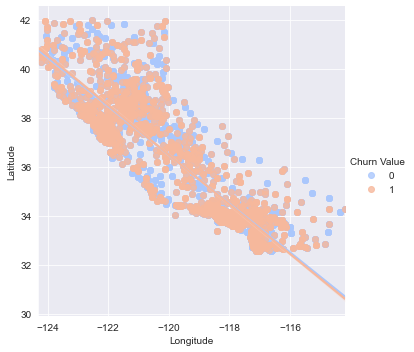

In [13]:
sns.lmplot(x='Longitude', y='Latitude', data=df, hue='Churn Value', palette='coolwarm')

In [14]:
r, p = pearsonr(df['Longitude'], df['Latitude'])

print('Pearsons correlation: %.3f' % r)
print('P-value correlation: ', p)

Pearsons correlation: -0.877
P-value correlation:  0.0


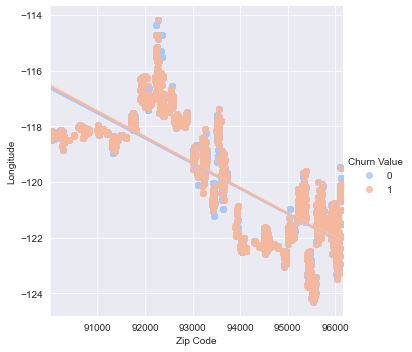

In [15]:
sns.lmplot(x='Zip Code', y='Longitude', data=df, hue='Churn Value', palette='coolwarm')

In [16]:
r, p = pearsonr(df['Zip Code'], df['Longitude'])

print('Pearsons correlation: %.3f' % r)
print('P-value correlation: ', p)

Pearsons correlation: -0.784
P-value correlation:  0.0


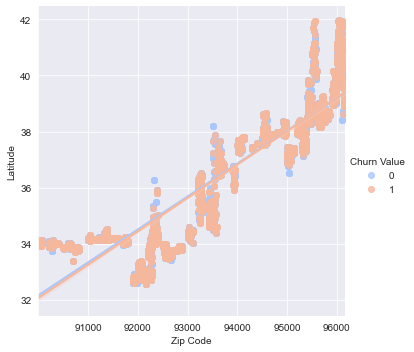

In [17]:
sns.lmplot(x='Zip Code', y='Latitude', data=df, hue='Churn Value', palette='coolwarm')

In [18]:
r, p = pearsonr(df['Zip Code'], df['Latitude'])

print('Pearsons correlation: %.3f' % r)
print('P-value correlation: ', p)

Pearsons correlation: 0.896
P-value correlation:  0.0


In [19]:
for i in df.columns:
    print(i)
    print("Number of unique values: ", df[i].nunique())
    print([df[i].unique()])
    print()

CustomerID
Number of unique values:  7043
[array(['3668-QPYBK', '9237-HQITU', '9305-CDSKC', ..., '2234-XADUH',
       '4801-JZAZL', '3186-AJIEK'], dtype=object)]

Count
Number of unique values:  1
[array([1], dtype=int64)]

Country
Number of unique values:  1
[array(['United States'], dtype=object)]

State
Number of unique values:  1
[array(['California'], dtype=object)]

City
Number of unique values:  1129
[array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)]

Zip Code
Number of unique values:  1652
[array([90003, 90005, 90006, ..., 96128, 96134, 96146], dtype=int64)]

Lat Long
Number of unique values:  1652
[array(['33.964131, -118.272783', '34.059281, -118.30742',
       '34.048013, -118.293953', ..., '40.346634, -120.386422',
       '41.813521, -121.492666', '39.191797, -120.212401'], dtype=object)]

Latitude
Number of unique values:  1652
[array([33.964131, 34.059281, 34.048013, ..., 40.346634, 41.813521,
 

In [20]:
df['Churn Reason'].value_counts()

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Lack of affordable download/upload speed      44
Long distance charges                         44
Limited range of services                     44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

<AxesSubplot:xlabel='count', ylabel='Churn Reason'>

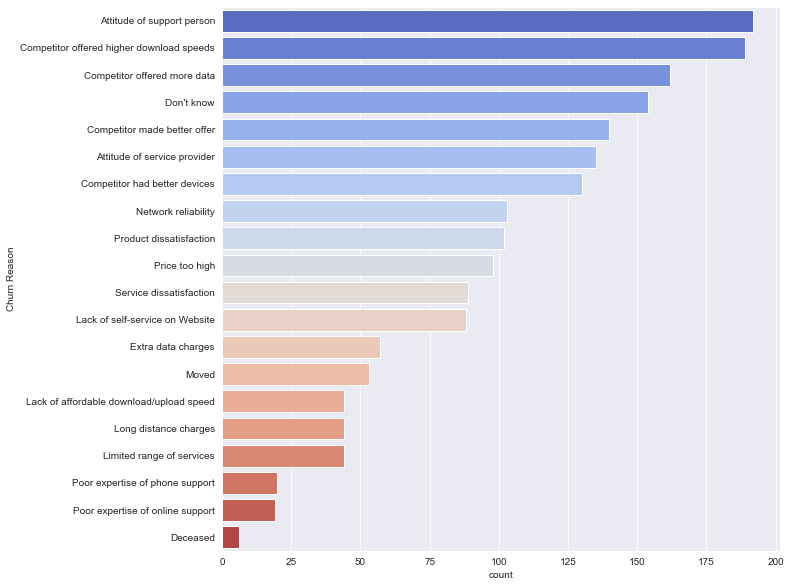

In [21]:
plt.figure(figsize=(10,10))
sns.countplot(y='Churn Reason', data=df, palette='coolwarm', 
              order = df['Churn Reason'].value_counts().index)

In [22]:
with pd.option_context("display.max_rows", 2000):
    print(df['Tenure Months'].value_counts())

1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
70    119
9     119
12    117
10    116
6     110
13    109
68    100
11     99
15     99
67     98
18     97
69     95
24     94
22     90
66     89
35     88
17     87
23     85
56     80
52     80
64     80
16     80
26     79
25     79
60     76
61     76
65     76
14     76
46     74
19     73
27     72
29     72
30     72
63     72
20     71
62     70
41     70
53     70
32     69
50     68
54     68
51     68
47     68
58     67
49     66
31     65
43     65
42     65
34     65
57     65
37     65
40     64
48     64
55     64
33     64
21     63
45     61
59     60
38     59
28     57
39     56
44     51
36     50
0      11
Name: Tenure Months, dtype: int64


<AxesSubplot:xlabel='count', ylabel='Tenure Months'>

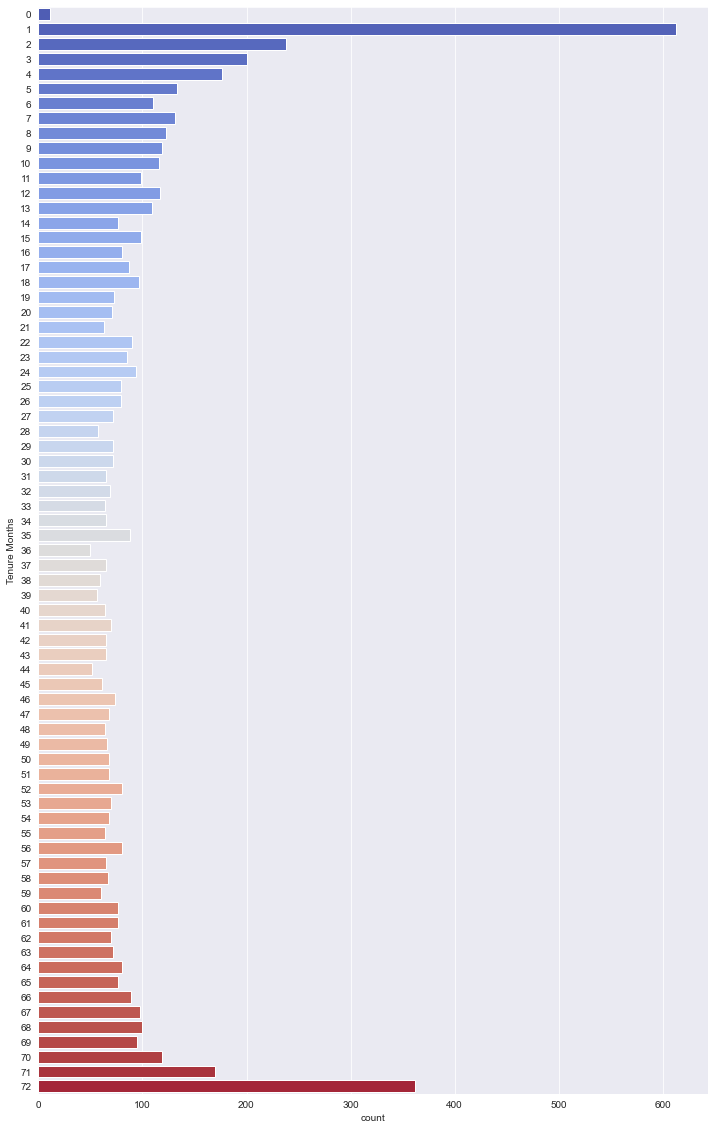

In [23]:
plt.figure(figsize=(12,20))
sns.countplot(y='Tenure Months', data=df, palette='coolwarm')

<AxesSubplot:xlabel='count', ylabel='Tenure Months'>

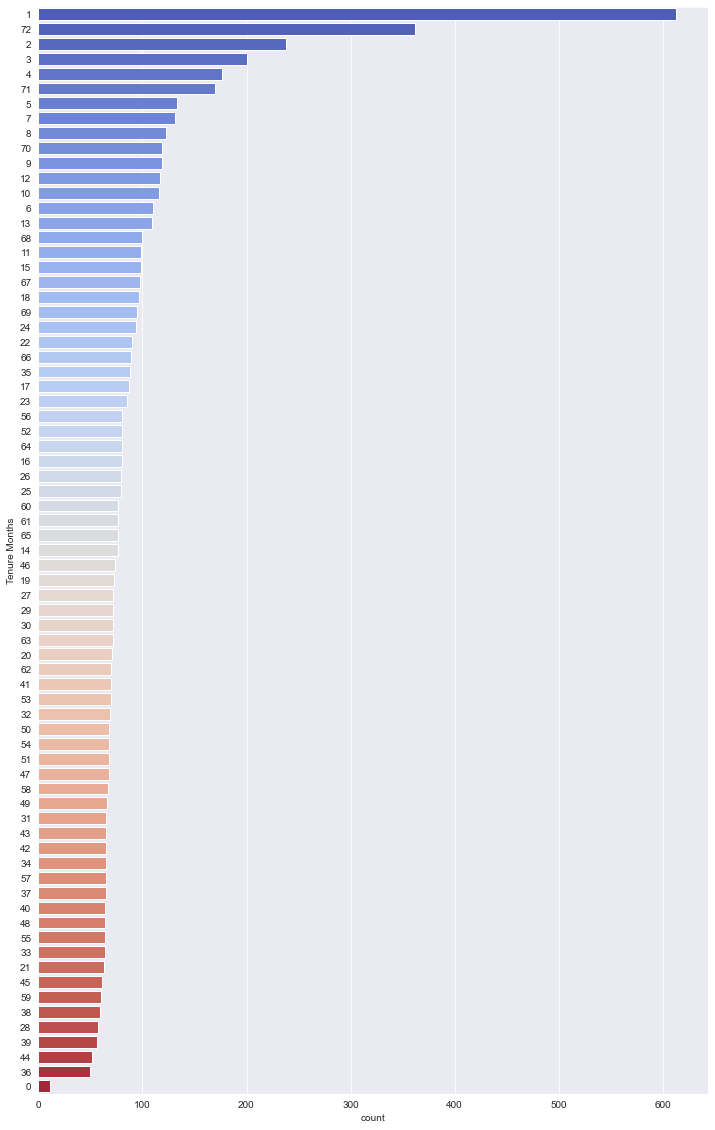

In [24]:
plt.figure(figsize=(12,20))
sns.countplot(y='Tenure Months', data=df, order=df['Tenure Months'].value_counts().index , palette='coolwarm')

<AxesSubplot:xlabel='count', ylabel='Tenure Months'>

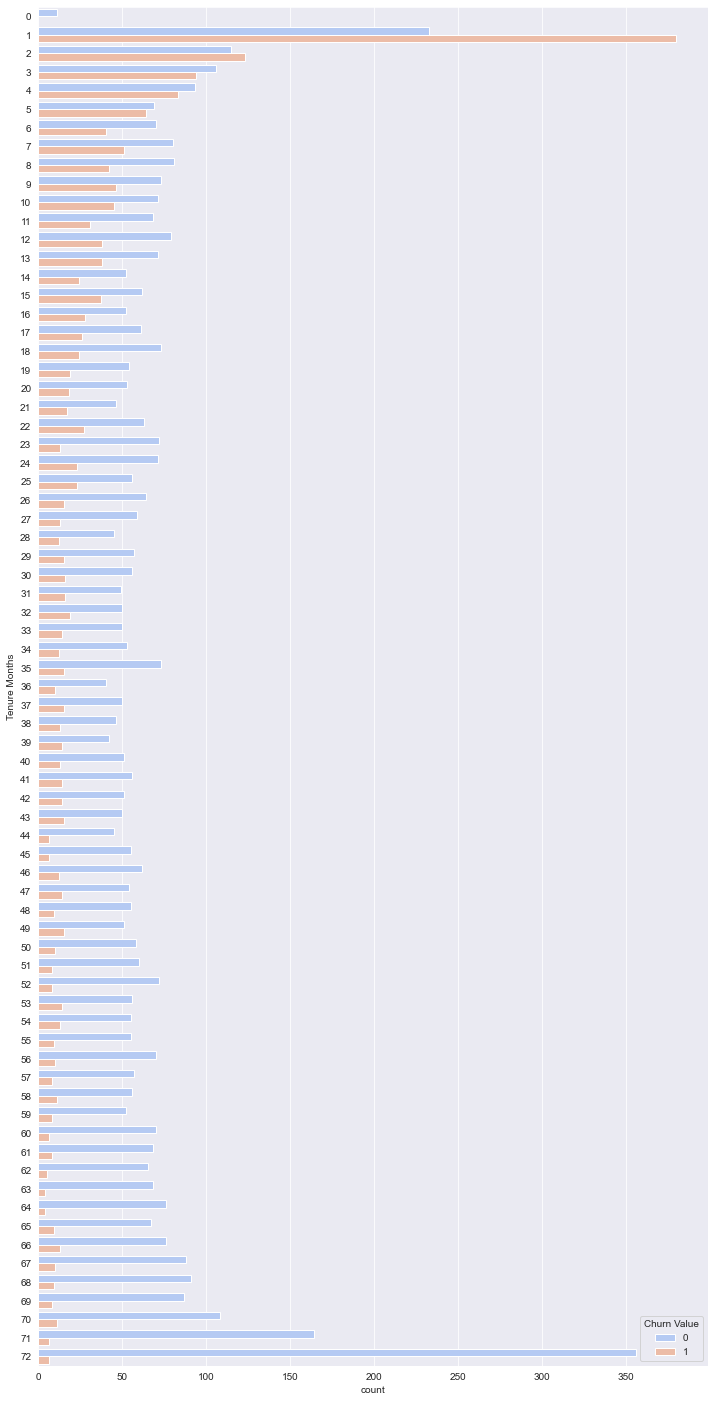

In [25]:
plt.figure(figsize=(12,25))
sns.countplot(y='Tenure Months', data=df, palette='coolwarm',
             hue='Churn Value')

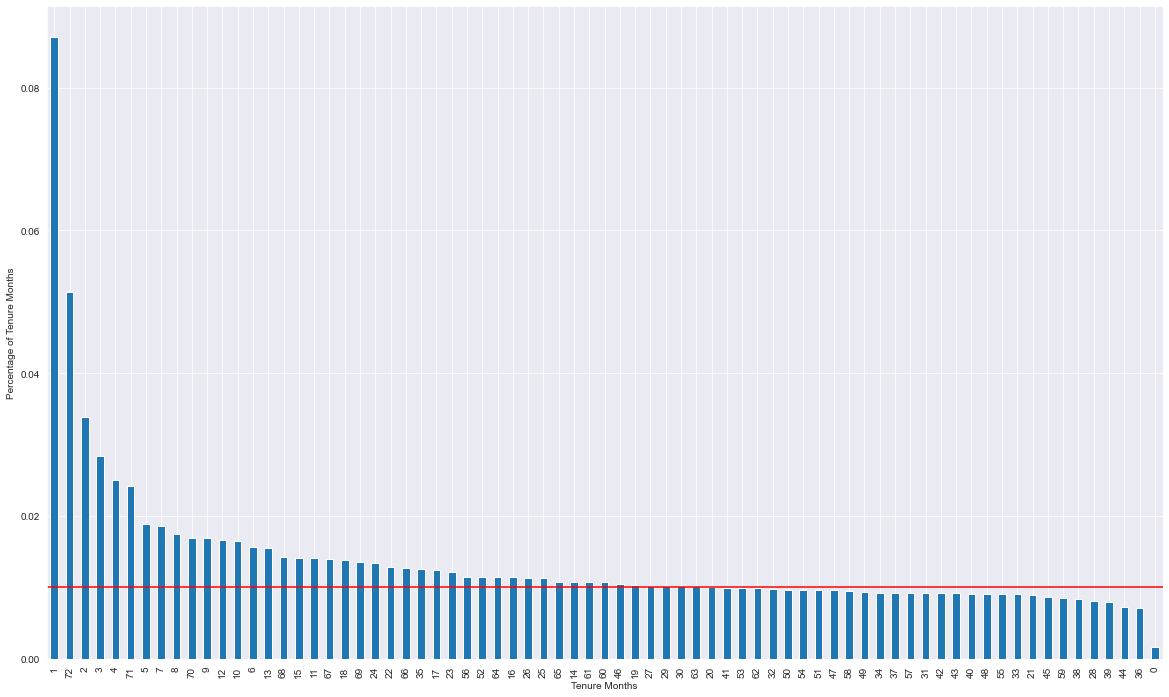

In [26]:
plt.figure(figsize=(20,12))

temp_df = pd.Series(df['Tenure Months'].value_counts(dropna=False) / 
                        len(df))

# Make plot with the above percentages
fig = temp_df.sort_values(ascending=False).plot.bar()
fig.set_xlabel('Tenure Months')
    
# Add a line at 1% to flage the threshold for rare categories
fig.axhline(y=0.01, color='red')
fig.set_ylabel('Percentage of Tenure Months')
plt.show()

In [27]:
with pd.option_context("display.max_rows", 2000):
    print(temp_df)

1     0.087037
72    0.051399
2     0.033792
3     0.028397
4     0.024989
71    0.024137
5     0.018884
7     0.018600
8     0.017464
70    0.016896
9     0.016896
12    0.016612
10    0.016470
6     0.015618
13    0.015476
68    0.014198
11    0.014057
15    0.014057
67    0.013915
18    0.013773
69    0.013489
24    0.013347
22    0.012779
66    0.012637
35    0.012495
17    0.012353
23    0.012069
56    0.011359
52    0.011359
64    0.011359
16    0.011359
26    0.011217
25    0.011217
60    0.010791
61    0.010791
65    0.010791
14    0.010791
46    0.010507
19    0.010365
27    0.010223
29    0.010223
30    0.010223
63    0.010223
20    0.010081
62    0.009939
41    0.009939
53    0.009939
32    0.009797
50    0.009655
54    0.009655
51    0.009655
47    0.009655
58    0.009513
49    0.009371
31    0.009229
43    0.009229
42    0.009229
34    0.009229
57    0.009229
37    0.009229
40    0.009087
48    0.009087
55    0.009087
33    0.009087
21    0.008945
45    0.008661
59    0.00

Check the City feature. It has high cardinality with plenty of rare Califonia cities.

In [28]:
with pd.option_context("display.max_rows", 2000):
    print(df['City'].value_counts())

Los Angeles               305
San Diego                 150
San Jose                  112
Sacramento                108
San Francisco             104
Fresno                     64
Long Beach                 60
Oakland                    52
Stockton                   44
Bakersfield                40
Glendale                   40
Berkeley                   32
Riverside                  32
Whittier                   30
Pasadena                   30
Modesto                    28
Santa Barbara              28
Anaheim                    28
Irvine                     28
San Bernardino             28
Inglewood                  25
Torrance                   25
Burbank                    25
Chula Vista                25
Santa Monica               25
Santa Ana                  24
Santa Rosa                 24
Garden Grove               20
Rancho Cucamonga           20
Orange                     20
North Hollywood            20
Salinas                    20
Corona                     20
Van Nuys  

Check the Zip Code feature. Find the relationship with City.

In [29]:
with pd.option_context("display.max_rows", 2000):
    print(df['Zip Code'].value_counts())

92173    5
92201    5
92057    5
90010    5
92061    5
90014    5
92065    5
90018    5
92069    5
90022    5
90026    5
90034    5
90038    5
90042    5
90046    5
92101    5
92105    5
90058    5
92109    5
90062    5
92113    5
90006    5
90002    5
92037    5
91901    5
91737    5
91741    5
91745    5
91761    5
91765    5
91773    5
91789    5
91801    5
91905    5
92029    5
91913    5
91917    5
91941    5
91945    5
91977    5
92009    5
92021    5
92025    5
90066    5
92121    5
91709    5
92129    5
90274    5
90278    5
90290    5
90302    5
90402    5
90502    5
90602    5
90606    5
90630    5
90638    5
90650    5
90670    5
90706    5
90710    5
90742    5
90746    5
90802    5
90806    5
90810    5
90270    5
90266    5
90262    5
90210    5
92203    5
92211    5
92223    5
92227    5
92231    5
92239    5
92243    5
92251    5
92259    5
92307    5
92267    5
90222    5
92275    5
90230    5
92283    5
90242    5
90250    5
90254    5
91733    5
91701    5
90822    5

In [30]:
df_counts = df.groupby(['City', 'Zip Code'])['City'].count()
with pd.option_context("display.max_rows", 2000):
    print(df_counts.loc[df['City'].value_counts().index])

City                    Zip Code
Los Angeles             90001       5
                        90002       5
                        90003       5
                        90004       5
                        90005       5
                        90006       5
                        90007       5
                        90008       5
                        90010       5
                        90011       5
                        90012       5
                        90013       5
                        90014       5
                        90015       5
                        90016       5
                        90017       5
                        90018       5
                        90019       5
                        90020       5
                        90021       5
                        90022       5
                        90023       5
                        90024       5
                        90025       5
                        90026       5
                 

Zip Code is basically further breakdown of the City, it takes the first 3 digit to represent the City. Accumulate of these Zip Code(s) per city is the same number as we accumulate the number for City. This will create high correlation and redundancy to the model.

In [31]:
# df['Zip Code'] = df['Zip Code'].astype(str).str[:3].astype(int)

<AxesSubplot:xlabel='CLTV'>

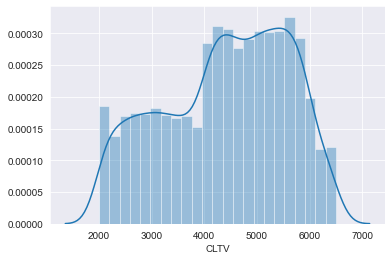

In [32]:
sns.distplot(df['CLTV'])

<AxesSubplot:xlabel='Tenure Months'>

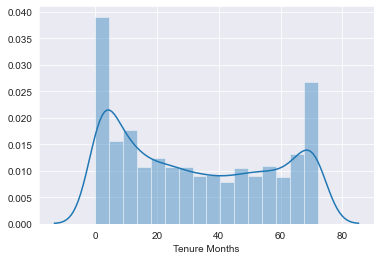

In [33]:
sns.distplot(df['Tenure Months'])

In [34]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # Plot 1
    plt.subplot(1, 2, 1)
    sns.countplot(variable, data=df)
    
    # Plot 2
    plt.subplot(1, 2, 2)
    sns.countplot(variable, hue='Churn Value', data=df)
    
    
    plt.show()

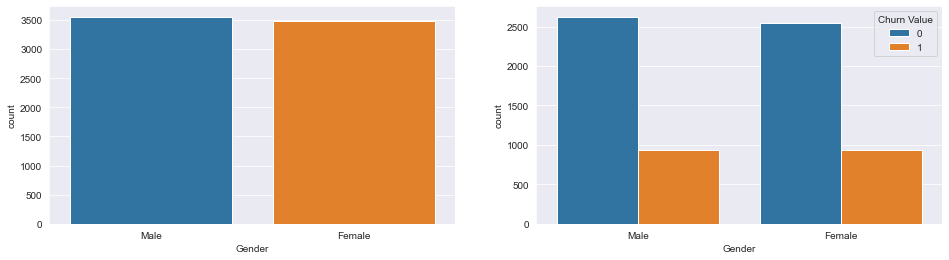

In [35]:
diagnostic_plots(df, 'Gender')

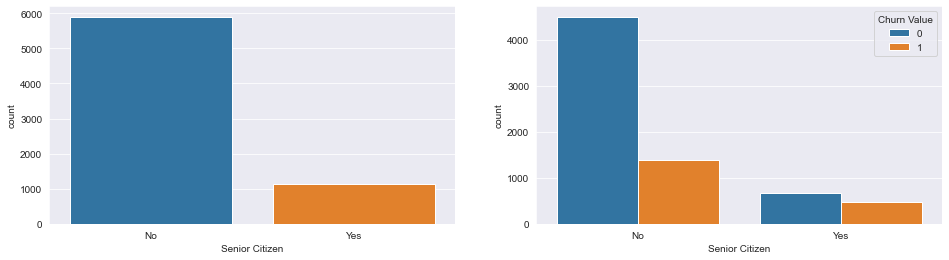

In [36]:
diagnostic_plots(df, 'Senior Citizen')

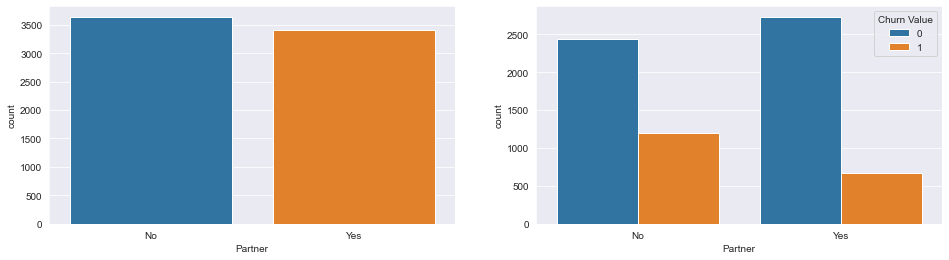

In [37]:
diagnostic_plots(df, 'Partner')

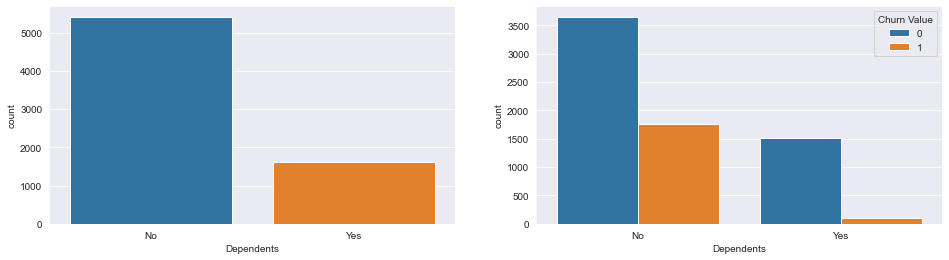

In [38]:
diagnostic_plots(df, 'Dependents')

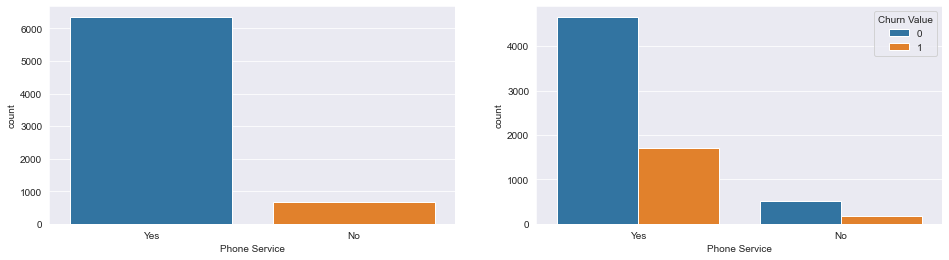

In [39]:
diagnostic_plots(df, 'Phone Service')

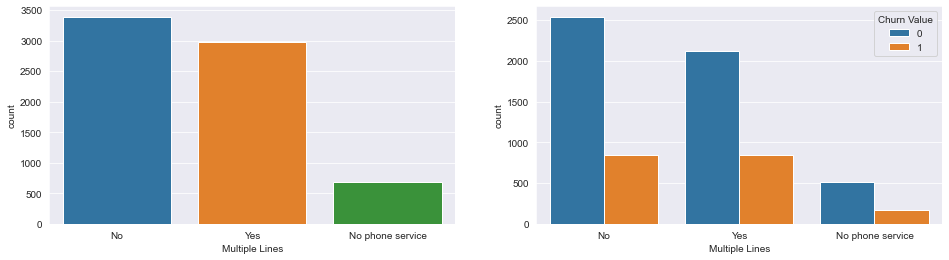

In [40]:
diagnostic_plots(df, 'Multiple Lines')

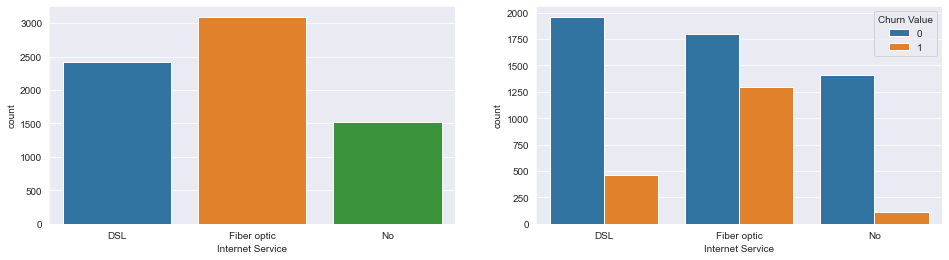

In [41]:
diagnostic_plots(df, 'Internet Service')

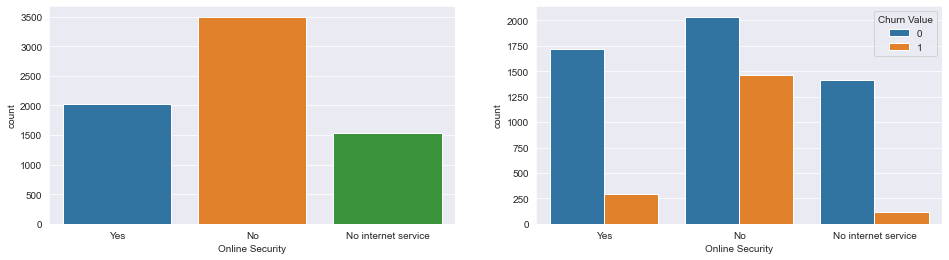

In [42]:
diagnostic_plots(df, 'Online Security')

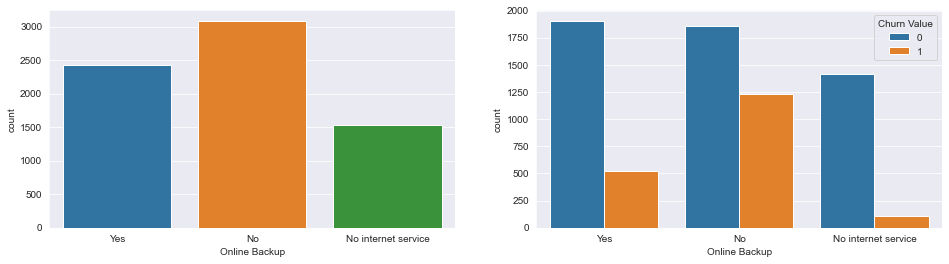

In [43]:
diagnostic_plots(df, 'Online Backup')

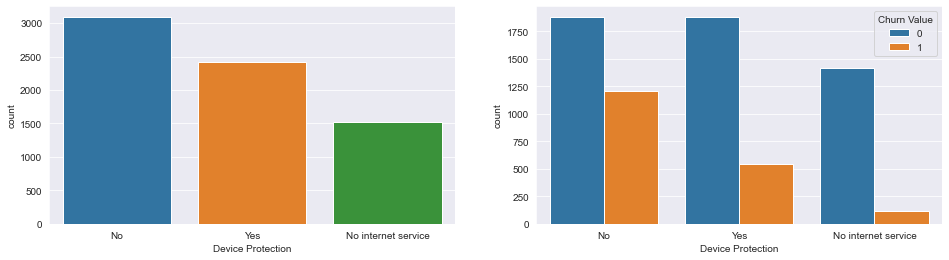

In [44]:
diagnostic_plots(df, 'Device Protection')

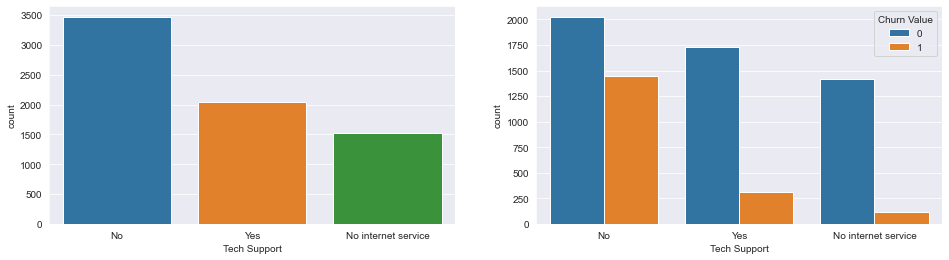

In [45]:
diagnostic_plots(df, 'Tech Support')

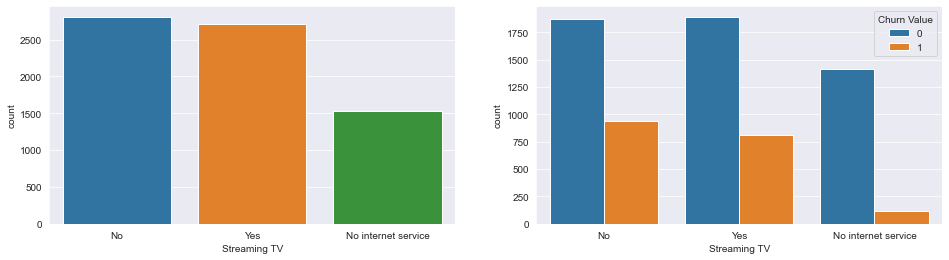

In [46]:
diagnostic_plots(df, 'Streaming TV')

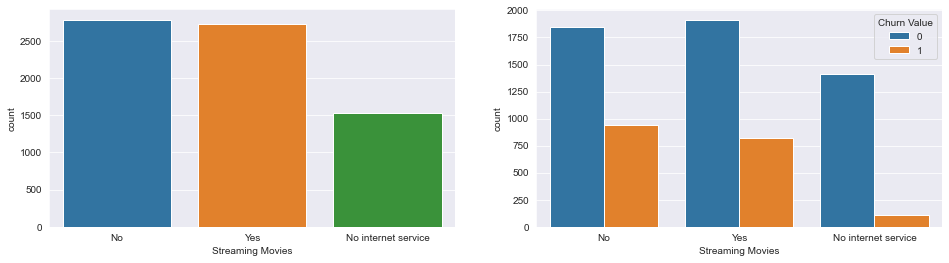

In [47]:
diagnostic_plots(df, 'Streaming Movies')

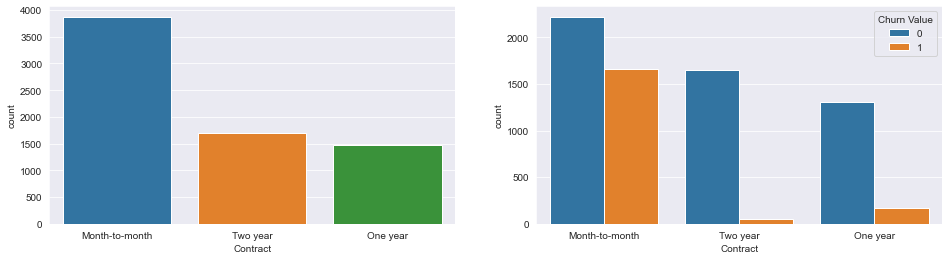

In [48]:
diagnostic_plots(df, 'Contract')

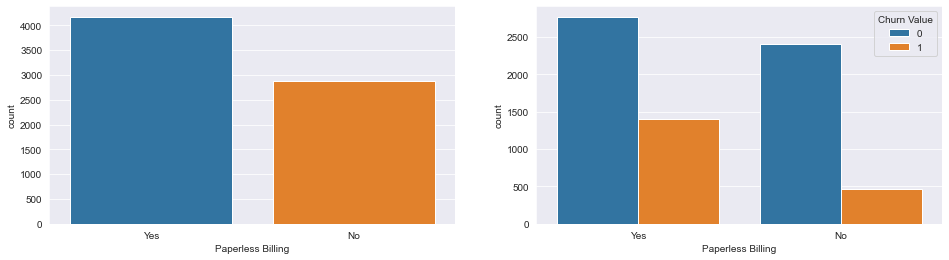

In [49]:
diagnostic_plots(df, 'Paperless Billing')

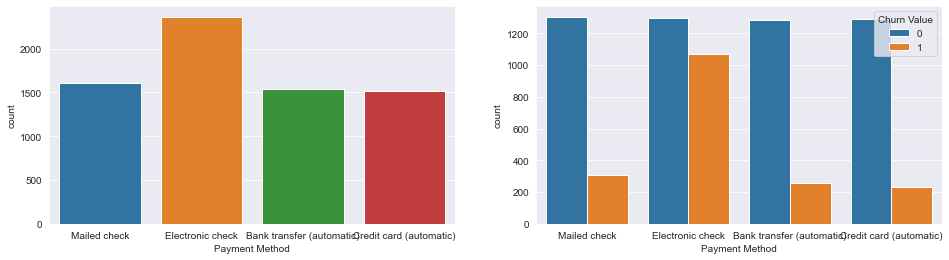

In [50]:
diagnostic_plots(df, 'Payment Method')

The last four variables (**Churn Label**, **Churn Score**, **CLTV** and **Churn Reason**) contain exit interview information and should not be used for prediction, so we will remove them.

In [51]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'],
       axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Some of the other columns only contain a single value, and will not be useful for classification.
For example:

In [52]:
for i in df.columns:
    print(i)
    print("Number of unique values: ", df[i].nunique())
    print([df[i].unique()])
    print()

CustomerID
Number of unique values:  7043
[array(['3668-QPYBK', '9237-HQITU', '9305-CDSKC', ..., '2234-XADUH',
       '4801-JZAZL', '3186-AJIEK'], dtype=object)]

Count
Number of unique values:  1
[array([1], dtype=int64)]

Country
Number of unique values:  1
[array(['United States'], dtype=object)]

State
Number of unique values:  1
[array(['California'], dtype=object)]

City
Number of unique values:  1129
[array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)]

Zip Code
Number of unique values:  1652
[array([90003, 90005, 90006, ..., 96128, 96134, 96146], dtype=int64)]

Lat Long
Number of unique values:  1652
[array(['33.964131, -118.272783', '34.059281, -118.30742',
       '34.048013, -118.293953', ..., '40.346634, -120.386422',
       '41.813521, -121.492666', '39.191797, -120.212401'], dtype=object)]

Latitude
Number of unique values:  1652
[array([33.964131, 34.059281, 34.048013, ..., 40.346634, 41.813521,
 

**Count**, **Country** and **State** contain only a single value.

In [53]:
df['Count'].unique()

array([1], dtype=int64)

In [54]:
df['Country'].unique()

array(['United States'], dtype=object)

In [55]:
df['State'].unique()

array(['California'], dtype=object)

So we can omit those variables. In contrast, `City` contains a bunch of different city names, so we will leave it in.

In [56]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

Check the cardinality of `City`:

In [57]:
df['City'].value_counts()

Los Angeles      305
San Diego        150
San Jose         112
Sacramento       108
San Francisco    104
                ... 
Pioneer            4
Fairfield          4
Chilcoot           4
Lathrop            4
Junction City      4
Name: City, Length: 1129, dtype: int64

In [58]:
df['Tenure Months'].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: Tenure Months, Length: 73, dtype: int64

Check `Total Charges`, looks like a string (`object`) but looks like a continuous value:

In [59]:
df['Total Charges'].value_counts()

          11
20.2      11
19.75      9
19.9       8
19.65      8
          ..
3554.6     1
1416.5     1
272.35     1
641.15     1
2802.3     1
Name: Total Charges, Length: 6531, dtype: int64

Looks like there is '' empty string, totall 11.

We will also remove `Customer ID` because it is different for every customer and useless for classification. Lastly, we will drop `Lat Long` because there are separate colums for `Latitude` and `Longtitue`. 

In [60]:
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'],
       axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


**NOTE:** Although it is OK to have whitespace in the city names in **City** for **XGBoost** and classification, we can't have any whitespace if we want to draw a tree. So let's take care of that now by replacing the white space in the city names with an underscore character `_`.

**ALSO NOTE** We can easily remove whitespace from all value, not just city names, but we will wait until after we have identified missing values.

In [61]:
df['City'].replace(' ', '_', regex=True, inplace=True)

In [62]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

We also need to eliminate the whitespace in the column names, so we'll replace it with underscores.

In [63]:
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Hooray! We have removed all of the data that will not help use create an effective **XGBoost** model and reformatted the column names and city names so that we can draw a tree. Now we are ready to identify and deal with **Missing Data**.


----

<a id="identify-and-deal-with-missing-data"></a>
# Missing Data Part 1 : Identifying Missing Data

Unfortunately, the biggest part of any data analysis project is making sure that the data are correctly formatted and fixing it when it is not. The first part of this process is identifying **Mising Data**.

**Missing Data** is simply a blank space, or a surrogate value like **NA**, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

One thing that is relatively unique about **XGBoost** is that it has default behaviour for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

In this section, we'll focus on identifying missing values in the dataset.

First, let's see what sort of data is in each column.

In [64]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

A lot of the columns are `object`, and this OK, because, as we saw above when we ran `head()` there were a lot of text responses, like `Yes` and `No`. However, let's verify that we are getting what we expect.

In [65]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

In [66]:
for i in df.columns:
    print(i)
    print([df[i].unique()])
    print()

City
[array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)]

Zip_Code
[array([90003, 90005, 90006, ..., 96128, 96134, 96146], dtype=int64)]

Latitude
[array([33.964131, 34.059281, 34.048013, ..., 40.346634, 41.813521,
       39.191797])]

Longitude
[array([-118.272783, -118.30742 , -118.293953, ..., -120.386422,
       -121.492666, -120.212401])]

Gender
[array(['Male', 'Female'], dtype=object)]

Senior_Citizen
[array(['No', 'Yes'], dtype=object)]

Partner
[array(['No', 'Yes'], dtype=object)]

Dependents
[array(['No', 'Yes'], dtype=object)]

Tenure_Months
[array([ 2,  8, 28, 49, 10,  1, 47, 17,  5, 34, 11, 15, 18,  9,  7, 12, 25,
       68, 55, 37,  3, 27, 20,  4, 58, 53, 13,  6, 19, 59, 16, 52, 24, 32,
       38, 54, 43, 63, 21, 69, 22, 61, 60, 48, 40, 23, 39, 35, 56, 65, 33,
       30, 45, 46, 62, 70, 50, 44, 71, 26, 14, 41, 66, 64, 29, 42, 67, 51,
       31, 57, 36, 72,  0], dtype=int64)]

Phone_Service
[array

So, **Phone_Service** has type `object` because it contains text, and it only contains two values, `Yes` and `No`. So this is good. Now, in practise, we would check each other column, but right now we will focus on one specific coulmn that looks like it could be a problem: **Total_Charges**.

If we look at the output from `head()`, **Total_Charges** looks like it contains numbers, not text, but the `object` datatype suggest that it contains more than just numbers. If we try the trick of printing out the unique values...

In [67]:
df['Total_Charges'].unique()

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

...we see that there are too many values to print and what little we see looks like numbers. However, if we try to convert the column to numeric values...

In [68]:
# NOTE: The next line is commented out, but you should
# uncomment it and run it so you can see the error that it 
# generates.
#
# The only reason it is commented out is that if you want
# to just run all of the python code at once, the next line 
# will cause Python to quit early because it creates an error.
#
# However, the error is useful for learning how to spot missing
# data, so that is why you should uncomment it and run it if you can.

# df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

...we get an error. This error, however, tells us what the problem is. There are blank spaces, `" "`, in the data. So we need to deal with those.

In [69]:
df['Total_Charges'].value_counts()

          11
20.2      11
19.75      9
19.9       8
19.65      8
          ..
3554.6     1
1416.5     1
272.35     1
641.15     1
2802.3     1
Name: Total_Charges, Length: 6531, dtype: int64


----

# Missing Data Part 2: Dealing With Missing Data, XGBoost Style

One thing is relatively unique about **XGBoost** is that it determines default behaviour for missing data. So all we have to do is identify missing values and make sure they are set to `0`. 

Howerver, before we do that, let's see how many rows are missing data. If it's a lot, then we might have a problem on our hands that bigger what **XGBoost** can deal with on its own. If it's not that manay, we can just set them to `0`.

In [70]:
len(df.loc[df['Total_Charges'] == ' '])

11

Since only **11** rows have missing values, let's look at them.

In [71]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We se that all **11** people with `Total_Charges == ' '` have just signed up, because **Tenure_Months** is `0`. These people also have **Churn_Value** set to `0` because they just signed up. So we have a few choices here, we can set **Total_Charges** to `0` for these **11** people or we can remove them. In this example, we'll try setting **Total_Charges** to `0`.

In [72]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0

Now let's verify that we modified **Total_Charges** correctly by looking at everyone who had **Tenure Months** set to `0`.

In [73]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


**BAM!** We have verified that `df` contains `0`s instead of `' '`s for missing values. **NOTE: Total_Charges** still has the `object` data type. That is no good because **XGBoost** only allows `int`, `float`, or `boolean` data types. We can fix this by converting it with `to_numeric()`.

In [74]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [75]:
df['Total_Charges'].value_counts()

0.00       11
20.20      11
19.75       9
19.90       8
20.05       8
           ..
1401.15     1
154.65      1
389.10      1
6383.35     1
5867.00     1
Name: Total_Charges, Length: 6531, dtype: int64

Now that we have dealt with the missing data, we can replace all of the other whitespaces in all of the columns with underscores. **NOTE:** we are only doing this so we can draw a picture of the one of the **XGBoost** trees.

In [76]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


In [77]:
for i in df.columns:
    print(i)
    print([df[i].unique()])
    print()

City
[array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)]

Zip_Code
[array([90003, 90005, 90006, ..., 96128, 96134, 96146], dtype=int64)]

Latitude
[array([33.964131, 34.059281, 34.048013, ..., 40.346634, 41.813521,
       39.191797])]

Longitude
[array([-118.272783, -118.30742 , -118.293953, ..., -120.386422,
       -121.492666, -120.212401])]

Gender
[array(['Male', 'Female'], dtype=object)]

Senior_Citizen
[array(['No', 'Yes'], dtype=object)]

Partner
[array(['No', 'Yes'], dtype=object)]

Dependents
[array(['No', 'Yes'], dtype=object)]

Tenure_Months
[array([ 2,  8, 28, 49, 10,  1, 47, 17,  5, 34, 11, 15, 18,  9,  7, 12, 25,
       68, 55, 37,  3, 27, 20,  4, 58, 53, 13,  6, 19, 59, 16, 52, 24, 32,
       38, 54, 43, 63, 21, 69, 22, 61, 60, 48, 40, 23, 39, 35, 56, 65, 33,
       30, 45, 46, 62, 70, 50, 44, 71, 26, 14, 41, 66, 64, 29, 42, 67, 51,
       31, 57, 36, 72,  0], dtype=int64)]

Phone_Service
[array


----

<a id="format-the-data"></a>
# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making an **XGBoost** model.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of dat that we want to predict.

We will use the conventional of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **Y**) to represent the thing we want to predict. In this case, we want to use predict **Churn Value** (whether or not someone will leave the company).

The reason we deal with missing data before splitting it into **X** and **y** is that if remove rows, splitting after ensure that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and remove the missing values etc.

In [78]:
X = df.drop('Churn_Value', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [79]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready to continue formatting **X** so that it is suitable for making a model with **XGBoost**.


----

<a id="Label-Encoding"></a>
# Format the Data Part 2: Label Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our trainning dataset, we need to take a closer look at the variables in `X`. The list below tells us what each varaible represents and the type of data (**float** or **categorical**) it should contain:

- **City** - **Category**
    - Los Angeles, Breverly Hills, etc
- **Zip Code** - **Category**
    - 90003, 90005, etc.
- **Latitude** - **Float**
- **Longtitude** - **Float**
- **Gender** - **Category**
    - Female, Male
- **Senior Citizen** - **Category**
    - Yes, No
- **Partner** - **Category**
    - Yes, No
- **Dependents** - **Category**
    - Yes, No
- **Tenure Months** - **Float**
- **Phone Service** - **Category**
    - Yes, No
- **Multiple Lines** - **Category**
    - Yes, No
- **Internet Service** - **Category**
    - No, DSL, Fiber optic
- **Online Security** - **Category**
    - Yes, No
- **Online Backup** - **Category**
    - Yes, No
- **Device Protection** - **Category**
    - Yes, No
- **Tech Support** - **Category**
    - Yes, No
- **Streaming TV** - **Category**
    - Yes, No
- **Streaming Movies** - **Category**
    - Yes, No
- **Contract** - **Category**
    - Month-to-month, One year, Two year
- **Paperless Billing** - **Category**
    - Yes, No
- **Payment Method** - **Category**
    - Mailed check, Electronic check, etc...
- **Monthly Charges** - **Float**
- **Total Charges** - **Float**

Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

In [80]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

So, we see that **Latitude**, **Longtitude**, **Monthly_Charges** and **Total_Charges** are all `float64`, which is good, because we want them to be floating points numbers. All of the columns that are `object` type, however, need to be inspected to make sure they only contain reasonable values, and most, if not all of them, will need to change. This is because, while **XGBoost** natively support continuous data, like **Monthly_Charges** and **Total_Charges**, it does not natively support categorical data, like **Phone_Service**, which contains 2 different categories. Thus, in order to use categorical data with **XGBoost**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **Target Label Encoding**. This will make categorical variables as has a monotonic relationship with output variable.

In [81]:
ordinal_encoder = OrdinalEncoder(
    encoding_method='ordered',
    variables=['Payment_Method'])
ordinal_encoder.fit_transform(X, y)
# pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,2,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,3,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,3,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,3,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,1,103.70,5036.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,92285,34.341737,-116.539416,Female,No,No,No,72,Yes,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,Yes,1,21.15,1419.40
7039,Adelanto,92301,34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,...,No,Yes,Yes,Yes,Yes,One_year,Yes,2,84.80,1990.50
7040,Amboy,92304,34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,...,Yes,Yes,No,Yes,Yes,One_year,Yes,0,103.20,7362.90
7041,Angelus_Oaks,92305,34.167800,-116.864330,Female,No,Yes,Yes,11,No,...,No,No,No,No,No,Month-to-month,Yes,3,29.60,346.45


In [82]:
# In the encoder dict we can observe the numbers assigned to each categories
# for all the indicated variables

ordinal_encoder.encoder_dict_

{'Payment_Method': {'Credit_card_(automatic)': 0,
  'Bank_transfer_(automatic)': 1,
  'Mailed_check': 2,
  'Electronic_check': 3}}

In [83]:
# This is the list of variables that the encoder will transform

ordinal_encoder.variables

['Payment_Method']

In the encoder dictionary, these catergorical feature `Payment_Method` are mapped as:

- Credit_card_(automatic): 0
- Bank_transfer_(automatic): 1
- Mailed_check: 2
- Electronic_check: 3

In [84]:
ordinal_encoder = OrdinalEncoder(
    encoding_method='ordered',
    variables=['City',
                'Gender',
                'Senior_Citizen',
                'Partner',
                'Dependents',
                'Phone_Service',
                'Multiple_Lines',
                'Internet_Service',
                'Online_Security',
                'Online_Backup',
                'Device_Protection',
                'Tech_Support',
                'Streaming_TV',
                'Streaming_Movies',
                'Contract',
                'Paperless_Billing', 
                'Payment_Method'])
X_encoded = ordinal_encoder.fit_transform(X, y)

X_encoded.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,769,90003,33.964131,-118.272783,0,0,1,1,2,1,...,1,2,2,2,2,2,1,2,53.85,108.15
1,769,90005,34.059281,-118.307420,1,0,1,0,2,1,...,2,2,2,2,2,2,1,3,70.70,151.65
2,769,90006,34.048013,-118.293953,1,0,1,0,8,1,...,2,1,2,1,1,2,1,3,99.65,820.50
3,769,90010,34.062125,-118.315709,1,0,0,0,28,1,...,2,1,1,1,1,2,1,3,104.80,3046.05
4,769,90015,34.039224,-118.266293,0,0,1,0,49,1,...,1,1,2,1,1,2,1,1,103.70,5036.30


# BAM!!!

Now, one last thing before we build an **XGBoost** model. Let's verify that `y` only contains **1s** and **0s** with `unique()`:

In [85]:
y.unique()

array([1, 0], dtype=int64)

# Double BAM!!!

We have finally finishe formatting the data for making an **XGBoost** model, so let's do it!!!


----

<a id="build-tree"></a>
# Build A Preliminary XGBoost Model
At long last, the data is correctly formatted for making **XGBoost** model. Now we simply split the data into **training** and **testing** data sets and build the model. However, first, let's observe that this data that this data is is imbalanced by dividing the number of people who left the company, where `y = 1`, by the total number of peopl in the dataset.

In [86]:
df['Churn_Value'].value_counts()

0    5174
1    1869
Name: Churn_Value, dtype: int64

In [87]:
df['Churn_Value'].value_counts() / len(df)

0    0.73463
1    0.26537
Name: Churn_Value, dtype: float64

In [88]:
sum(y)/len(y)

0.2653698707936959

So we see that only **27%** of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both **training** set and the **testing** set.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,
                                                   random_state=42, stratify=y)

Now let's verify that using `stratify` worked as expected...

In [90]:
sum(y_train)/len(y_train)

0.2654297614539947

In [91]:
sum(y_test)/len(y_test)

0.26519023282226006

**BAM!!!** `stratify` worked as expected and both `y_train` and `y_test` have the same percentage of people that left the company. Now let's build the preliminary model.

Check the rare label before we split and after we split.

In [92]:
for i in ['City', 'Zip_Code', 'Tenure_Months']:
    print('Unique of original data, ', i, ' : ', X[i].nunique())
    print('Unique of train data, ', i, ' : ', X_train[i].nunique())
    print('Unique of test data, ', i, ' : ', X_test[i].nunique(), '\n')

Unique of original data,  City  :  1129
Unique of train data,  City  :  1127
Unique of test data,  City  :  828 

Unique of original data,  Zip_Code  :  1652
Unique of train data,  Zip_Code  :  1647
Unique of test data,  Zip_Code  :  1169 

Unique of original data,  Tenure_Months  :  73
Unique of train data,  Tenure_Months  :  73
Unique of test data,  Tenure_Months  :  73 



Tenure_Months is fine after split, no rare data. However, City and Zip_Code have high cardinality that eventually lead to rare label, tiny proportion of the observations in a dataset being split some available in train and test data. Data available in train dataset but missing in test set will eventually lead to overfitty, on the other hand, data available in test data set but missing in train data set will lead operational problem where the model cannot recognise data that are not availble in train data set.

**NOTE:** Instead of determine the optimal number of trees with cross validation, we will use **early stopping** to stop building trees when they no longer improve the situation.

In [93]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                            missing=None, seed=42, verbosity=1)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           ## the next three arguments set up early stopping.
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.69875
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.74150
[2]	validation_0-aucpr:0.74105
[3]	validation_0-aucpr:0.74605
[4]	validation_0-aucpr:0.75131
[5]	validation_0-aucpr:0.75206
[6]	validation_0-aucpr:0.76479
[7]	validation_0-aucpr:0.76610
[8]	validation_0-aucpr:0.76693
[9]	validation_0-aucpr:0.76529
[10]	validation_0-aucpr:0.76960
[11]	validation_0-aucpr:0.77146
[12]	validation_0-aucpr:0.77186
[13]	validation_0-aucpr:0.77552
[14]	validation_0-aucpr:0.77502
[15]	validation_0-aucpr:0.77530
[16]	validation_0-aucpr:0.77863
[17]	validation_0-aucpr:0.77979
[18]	validation_0-aucpr:0.78016
[19]	validation_0-aucpr:0.77890
[20]	validation_0-aucpr:0.77876
[21]	validation_0-aucpr:0.77937
[22]	validation_0-aucpr:0.78004
[23]	validation_0-aucpr:0.78017
[24]	validation_0-aucpr:0.78028
[25]	validation_0-aucpr:0.77960
[26]	validation_0-aucpr:0.77972
[27]	validation_0-aucpr:0.77900
[28]	validation_0-aucpr:0.77815
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=1)

<AxesSubplot:>

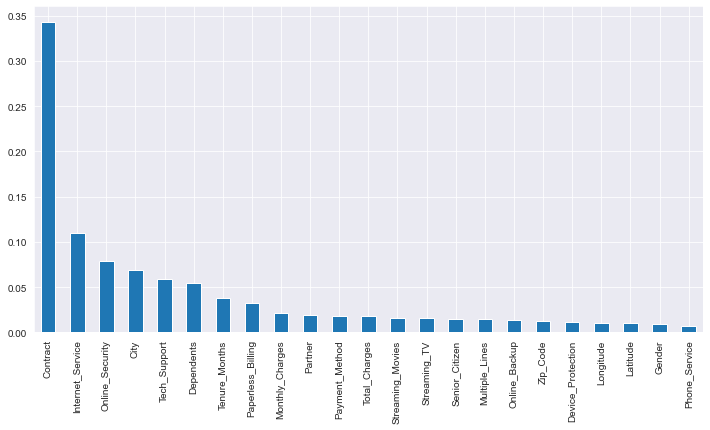

In [94]:
# Let's explore the importance of the features

importance = pd.Series(clf_xgb.feature_importances_)
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

OK, we've built an **XGBoost** model for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

In [95]:
print(classification_report(y_test,clf_xgb.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.8807    0.9189    0.8994      1294
           1     0.7445    0.6552    0.6970       467

    accuracy                         0.8489      1761
   macro avg     0.8126    0.7871    0.7982      1761
weighted avg     0.8446    0.8489    0.8457      1761



<img src="https://miro.medium.com/max/746/0*wKaznIJzZF54b87B.jpg" width="250" alt="Confusion Matrix">

**Accuracy:**
Accuracy is the most common performance metric used for classification algorithms. Accuracy is mainly used for a balanced dataset. It is defined as the ratio of the number of correct predictions made to all the prediction made.

\begin{align}
Accuracy & = \frac{TP+TN}{TP+TN+FP+FN} \\
\end{align}

- The Accuracy metric may not work well with **unbalanced** datasets as it may get biased towards the majority class.


**Precision:**
The precision metric used in information retrieval is defined as from all the points predicted to positive how many of them are actually positive.

\begin{align}
Precision & = \frac{TP}{TP+FP} \\
\end{align}

- The precision metric is used for machine learning models where **low False Positive (FP)** is important.


**Recall:**
The recall metric is also known as sensitivity is defined as from all the points which are actually positive how many of them are predicted to be positive. The recall is the same as the true positive rate (TPR).

\begin{align}
Recall & = \frac{TP}{TP+FN} \\
\end{align}

- The recall metric is used for Machine Learning models where **low False Negative (FN)** is important.

**F-beta score:** For Machine Learning models where both **False Negative (FN)** and **False Positive (FP)** have equal importance to be low, then we can use combine the advantage of Precision and Recall in a new metric called F-beta score.

\begin{align}
F_{1score} & = \frac{2*Precision*Recall}{Precision*Recall} \\
\end{align}

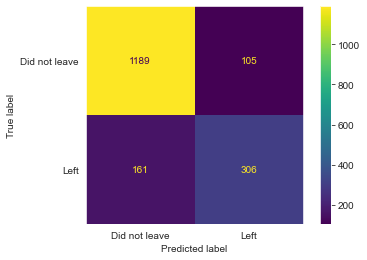

In [96]:
sns.set_style("dark")
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not leave", "Left"])

In the confusion matrix, we see that of the **1294** people that **did not leave**, **1,189 (91.9%)** were correctly classified. And of the **467** people that **left the company**, **306 (65.5%)** were correctly classified. So that **XGBoost** model was not awesome. Part of the problem is that our data is imbalanced, which we saw ealier and we see this in the confusion matrix with the top row showing **1,294** people that did not default and the bottom row showing **467** people who did. Because people leaving costs the company a lot of money, we would like to capture more of the people that left. The good news is that **XGBoost** has a parameter, `scale_pos_weight`, that helps with imbalanced data. So let's try to imporve predictions using **Cross Validation** to optimize the parameters.


----

<a id="optimize-parameters"></a>
# Optimize Parameters using Cross Validation and GridSearch()
**XGBoost** has a lot of *hyperparameters*, parameters that we have to manually configure and are not determined by **XGBoost** itself, including `max_depth`, the maximun tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, amd `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearch()`. We specify a bunch of potential values for the hyperparameters and `GridSearch()` tests all possible combinations of the parameters for us.

In [97]:
# ## NOTE: When data are imbalanced, the XGBoost manual says...
# ## If you care only about the overall performance metric (AUC) of your prediction
# ##     * Balance the positive and negative weights via scale_pos_weight
# ##     * Use AUC for evaluation
# ## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
# ## in order to optimize parameters in a short period of time.

## ROUND 1
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5] # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
# }
## Output: max_depth: 4, learning_rate: 0.1, gamma: 0.25, reg_lambda: 10, scale_pos_weight: 3
## Because learning_rate and reg_lambda were at the ends of their range, we will continue to explore those...

# ## ROUND 2
# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.1, 0.5, 1],
#     'gamma': [0.25],
#     'reg_lambda': [10.0, 20, 100],
#      'scale_pos_weight': [3]
# }
# ## Output: max_depth: 4, learning_rate: 0.1, reg_lambda: 10.

## NOTE: To speed up cross validiation, and to further prevent overfitting.
## We are only using a random subset of the data (90%) and are only
## using a random subset of the features (columns) (50%) per tree.
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', 
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5),
#     param_grid=param_grid,
#     scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
#     n_jobs = 10,
#     cv = 3
# )

# optimal_params.fit(X_train, 
#                    y_train, 
#                    early_stopping_rounds=10,                
#                    eval_metric='auc',
#                    eval_set=[(X_test, y_test)],
#                    verbose=False)
# print(optimal_params.best_params_)

In [98]:
# Find the exact scale_pos_weight ratio
ratio = np.round(float(np.sum(y_train == 0)) / np.sum(y_train == 1))
print(ratio)

3.0


In [99]:
## NOTE: When data are imbalanced, the XGBoost manual says...
## If you care only about the overall performance metric (AUC) of your prediction
##    * Balance the positve and negative weights via scale_pos_weight
##    * Use AUC for evaluation
## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
## in order to optimize parameters in a short period of time.

# ROUND 1
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'gamma': [0, 0.25, 0.5, 0.75, 1.0],
    'reg_lambda': [0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances) for normal imbalanced
    # Otherwise sqrt(sum(negative instances) / sum(positive instances)) for extremely imbalanced
    'scale_pos_weight': [ratio]
}
# Output: max_depth: 4, learning_rate: 0.1, gamma: 0.25, reg_lambda: 10, scale_pos_weight: 3
# Because learning_rate and reg_lambda were at the ends of their range, we will continue to explot those...

# NOTE: To speed up cross validation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only 
# using a random subset of the features (columns) (50%) per tree.
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                               seed=42,
                               n_estimators=100),
    param_grid=param_grid,
    scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=2, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_test, y_test)],
                  verbose=True)
print(optimal_params.best_params_)

Fitting 3 folds for each of 133650 candidates, totalling 400950 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   18.7s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   30.2s
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed:   41.6s
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:   55.7s
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done 7918 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 9093 tasks      | 

[0]	validation_0-auc:0.86399
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87477
[2]	validation_0-auc:0.88395
[3]	validation_0-auc:0.88988
[4]	validation_0-auc:0.89270
[5]	validation_0-auc:0.89503
[6]	validation_0-auc:0.89597
[7]	validation_0-auc:0.89694
[8]	validation_0-auc:0.89795
[9]	validation_0-auc:0.90010
[10]	validation_0-auc:0.90128
[11]	validation_0-auc:0.90171
[12]	validation_0-auc:0.90264
[13]	validation_0-auc:0.90312
[14]	validation_0-auc:0.90373
[15]	validation_0-auc:0.90403
[16]	validation_0-auc:0.90437
[17]	validation_0-auc:0.90455
[18]	validation_0-auc:0.90494
[19]	validation_0-auc:0.90491
[20]	validation_0-auc:0.90472
[21]	validation_0-auc:0.90551
[22]	validation_0-auc:0.90542
[23]	validation_0-auc:0.90599
[24]	validation_0-auc:0.90561
[25]	validation_0-auc:0.90603
[26]	validation_0-auc:0.90592
[27]	validation_0-auc:0.90608
[28]	validation_0-auc:0.90558
[29]	validation_0-auc:0.90526
[30]	validation_0-auc:0.90546
[31]	validation_

In [100]:
## ROUND 2
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.07, 0.08, 0.1, 0.3, 0.4, 0.7, 0.8],
    'gamma': [0.75],
    'reg_lambda': [5.0, 6.0, 10.0, 20.0, 100.0],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'scale_pos_weight': [ratio, ratio-1, ratio+1]
}
## Output: max_depth: 4, learning_rate: 0.1, reg_lambda: 10.

# NOTE: To speed up cross validation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only 
# using a random subset of the features (columns) (50%) per tree.
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                               seed=42,
                               n_estimators=100),
    param_grid=param_grid,
    scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=2, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_test, y_test)],
                  verbose=True)
print(optimal_params.best_params_)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   15.9s


[0]	validation_0-auc:0.86399
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87477
[2]	validation_0-auc:0.88395
[3]	validation_0-auc:0.88988
[4]	validation_0-auc:0.89270
[5]	validation_0-auc:0.89503
[6]	validation_0-auc:0.89597
[7]	validation_0-auc:0.89694
[8]	validation_0-auc:0.89795
[9]	validation_0-auc:0.90010
[10]	validation_0-auc:0.90128
[11]	validation_0-auc:0.90171
[12]	validation_0-auc:0.90264
[13]	validation_0-auc:0.90312
[14]	validation_0-auc:0.90373
[15]	validation_0-auc:0.90403
[16]	validation_0-auc:0.90437
[17]	validation_0-auc:0.90455
[18]	validation_0-auc:0.90494


[Parallel(n_jobs=10)]: Done 315 out of 315 | elapsed:   23.1s finished


[19]	validation_0-auc:0.90491
[20]	validation_0-auc:0.90472
[21]	validation_0-auc:0.90551
[22]	validation_0-auc:0.90542
[23]	validation_0-auc:0.90599
[24]	validation_0-auc:0.90561
[25]	validation_0-auc:0.90603
[26]	validation_0-auc:0.90592
[27]	validation_0-auc:0.90608
[28]	validation_0-auc:0.90558
[29]	validation_0-auc:0.90526
[30]	validation_0-auc:0.90546
[31]	validation_0-auc:0.90600
[32]	validation_0-auc:0.90579
[33]	validation_0-auc:0.90598
[34]	validation_0-auc:0.90591
[35]	validation_0-auc:0.90601
[36]	validation_0-auc:0.90622
[37]	validation_0-auc:0.90646
[38]	validation_0-auc:0.90656
[39]	validation_0-auc:0.90658
[40]	validation_0-auc:0.90677
[41]	validation_0-auc:0.90702
[42]	validation_0-auc:0.90689
[43]	validation_0-auc:0.90662
[44]	validation_0-auc:0.90663
[45]	validation_0-auc:0.90634
[46]	validation_0-auc:0.90637
[47]	validation_0-auc:0.90621
[48]	validation_0-auc:0.90594
[49]	validation_0-auc:0.90580
[50]	validation_0-auc:0.90539
[51]	validation_0-auc:0.90565
Stopping. 

So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=0.5`, `learning_rate=0.05`, `max_depth=5`, and `reg_lambda=6.0`.

----

<a id="draw-tree"></a>
# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [101]:
clf_xgb = xgb.XGBClassifier(seed=42, 
                            objective='binary:logistic',
                            n_estimators=200,
                            gamma=0.75,
                            learning_rate=0.1,
                            max_depth=5,
                            reg_lambda=6.0,
                            scale_pos_weight=ratio,
                            subsample=0.8,
                            colsample_bytree=0.7)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            ## the next three arguments set up early stopping.
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.86399
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87477
[2]	validation_0-auc:0.88395
[3]	validation_0-auc:0.88988
[4]	validation_0-auc:0.89270
[5]	validation_0-auc:0.89503
[6]	validation_0-auc:0.89597
[7]	validation_0-auc:0.89694
[8]	validation_0-auc:0.89795
[9]	validation_0-auc:0.90010
[10]	validation_0-auc:0.90128
[11]	validation_0-auc:0.90171
[12]	validation_0-auc:0.90264
[13]	validation_0-auc:0.90312
[14]	validation_0-auc:0.90373
[15]	validation_0-auc:0.90403
[16]	validation_0-auc:0.90437
[17]	validation_0-auc:0.90455
[18]	validation_0-auc:0.90494
[19]	validation_0-auc:0.90491
[20]	validation_0-auc:0.90472
[21]	validation_0-auc:0.90551
[22]	validation_0-auc:0.90542
[23]	validation_0-auc:0.90599
[24]	validation_0-auc:0.90561
[25]	validation_0-auc:0.90603
[26]	validation_0-auc:0.90592
[27]	validation_0-auc:0.90608
[28]	validation_0-auc:0.90558
[29]	validation_0-auc:0.90526
[30]	validation_0-auc:0.90546
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.75, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.0, scale_pos_weight=3.0, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

<AxesSubplot:>

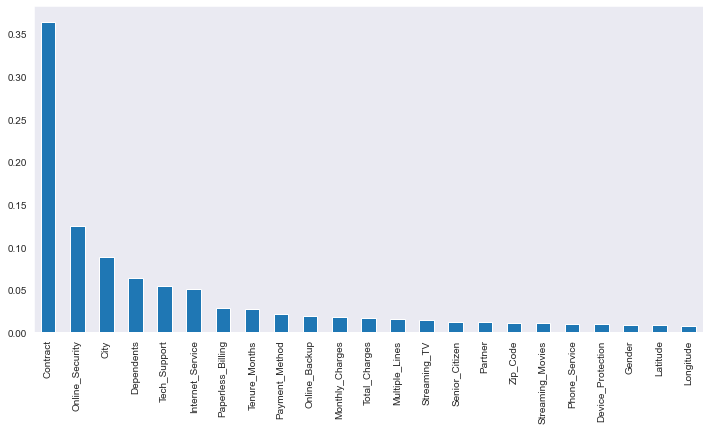

In [102]:
# Let's explore the importance of the features

importance = pd.Series(clf_xgb.feature_importances_)
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

1 		
- 0.5203 - 243
- 0.5310 - 248
		
2 		
- 0.7323 - 342
- 0.7473 - 349
		
2.77 	
- 0.8158 - 381
- 0.8266 - 386
		
3 		
- 0.8437 - 394
- 0.8308 - 388
		
4		
- 0.8715 - 407
- 0.8651 - 404

In [103]:
print(classification_report(y_test,clf_xgb.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.9428    0.7898    0.8595      1294
           1     0.5982    0.8672    0.7080       467

    accuracy                         0.8103      1761
   macro avg     0.7705    0.8285    0.7838      1761
weighted avg     0.8514    0.8103    0.8194      1761



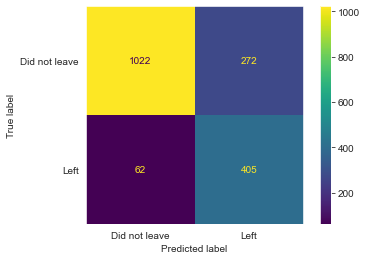

In [104]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not leave", "Left"])

We see that the optimized **XGBoost** model is a lot better at identifying people that left the company. Of the **467** people that left the company, **405 (86.7%)**, were correctly identified. Before optimization, we only correctly identified **306 (65.5%)**. However, this improvement was at the expense of not being able to correctly classify as many people that did not leave. Before optimization, we correctly identified **1,189 (91.9%)** people that did not leave. Now we only correctly classify **1,022 (79.0.7%)**. That said, this trade off may be better for the company becuase not it can focus resources on the people that leave if that will help them retain them.

<a id="deploy-model"></a>
# Deploy Model using pickle

In [105]:
# Save the model using picle
pickle.dump(clf_xgb, open(file_name, "wb"))

In [106]:
# Load 
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [144]:
pd.DataFrame(X_test.iloc[0]).T

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
6215,797.0,94518.0,37.950248,-122.022455,1.0,0.0,1.0,1.0,52.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,80.2,4297.6


In [152]:
# Test 
test = pd.DataFrame(X_test.iloc[0]).T
print(xgb_model_loaded.predict(test)[0] == clf_xgb.predict(test)[0])

True


In [169]:
X_test

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
6215,797,94518,37.950248,-122.022455,1,0,1,1,52,1,...,1,2,2,2,2,1,1,2,80.20,4297.60
4582,790,92117,32.825086,-117.199424,1,0,0,0,33,1,...,0,0,0,0,0,2,0,1,24.25,838.50
6444,159,95441,38.731771,-123.064272,0,0,0,0,10,0,...,1,1,1,2,1,0,0,0,53.70,521.00
6213,208,94513,37.908242,-121.682472,0,0,1,1,1,1,...,1,2,2,2,1,2,1,3,85.00,85.00
6605,226,95916,39.657228,-121.377780,0,0,0,0,52,0,...,1,1,1,1,2,0,0,2,50.20,2554.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,665,92384,35.924252,-116.188668,0,1,0,0,35,1,...,1,2,1,1,1,2,1,3,76.05,2747.20
422,913,96092,39.955164,-122.018567,0,1,0,1,13,1,...,1,2,1,2,1,2,1,1,89.05,1169.35
6880,350,91326,34.281911,-118.556218,0,0,1,1,39,1,...,2,1,2,1,1,0,1,3,100.45,3801.70
773,1088,95526,40.372532,-123.525626,1,0,0,0,3,0,...,2,2,1,2,2,2,1,2,31.00,95.05


In [170]:
X_test['Churn Label'] = y_test

d:\software\programming\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [171]:
X_test

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn Label
6215,797,94518,37.950248,-122.022455,1,0,1,1,52,1,...,2,2,2,2,1,1,2,80.20,4297.60,0
4582,790,92117,32.825086,-117.199424,1,0,0,0,33,1,...,0,0,0,0,2,0,1,24.25,838.50,0
6444,159,95441,38.731771,-123.064272,0,0,0,0,10,0,...,1,1,2,1,0,0,0,53.70,521.00,0
6213,208,94513,37.908242,-121.682472,0,0,1,1,1,1,...,2,2,2,1,2,1,3,85.00,85.00,0
6605,226,95916,39.657228,-121.377780,0,0,0,0,52,0,...,1,1,1,2,0,0,2,50.20,2554.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,665,92384,35.924252,-116.188668,0,1,0,0,35,1,...,2,1,1,1,2,1,3,76.05,2747.20,0
422,913,96092,39.955164,-122.018567,0,1,0,1,13,1,...,2,1,2,1,2,1,1,89.05,1169.35,1
6880,350,91326,34.281911,-118.556218,0,0,1,1,39,1,...,1,2,1,1,0,1,3,100.45,3801.70,0
773,1088,95526,40.372532,-123.525626,1,0,0,0,3,0,...,2,1,2,2,2,1,2,31.00,95.05,1


In [175]:
X_test.to_csv('TestData.csv')

In [176]:
df_test = pd.read_csv('TestData.csv')

In [177]:
df_test.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn Label
0,797,94518,37.950248,-122.022455,1,0,1,1,52,1,...,2,2,2,2,1,1,2,80.20,4297.6,0
1,790,92117,32.825086,-117.199424,1,0,0,0,33,1,...,0,0,0,0,2,0,1,24.25,838.5,0
2,159,95441,38.731771,-123.064272,0,0,0,0,10,0,...,1,1,2,1,0,0,0,53.70,521.0,0
3,208,94513,37.908242,-121.682472,0,0,1,1,1,1,...,2,2,2,1,2,1,3,85.00,85.0,0
4,226,95916,39.657228,-121.377780,0,0,0,0,52,0,...,1,1,1,2,0,0,2,50.20,2554.0,0
